## FP Analysis - Peak Detection
1. Date: Recording - 2024/05/15-16, Analysis - 2024/05/22-
2. Task: 3-Chamber test (E-E, S-E, S-S sessions)
3. Performer: Recording - YGKim, Analysis - YGKim
4. Animal: PV-Cre female and CHD8 WT/HT male 
5. Group, ID: as follows 

### 0. Import libraries

In [1]:
# import the libraries that we will use
import os
import pandas as pd
import numpy as  np
import pylab as plt
import VideoFunctions
from scipy.signal import find_peaks


### 1. Set file parameters and working dir 
Put everything that should be sepecified by user.

In [2]:
Base_folder = r'D:\DataAtCSBD\FiberPhotometry\ProcessedData' 
Batch_folder = '250114_B6' 
Animal_ID = 'G06_004'
Session = 'DI'

FPS = 25 #Frame per second of behavior data
Duration_sec = 600 #Recording duration of behavior data
SavePlots = False
SaveData = False
SaveVideos = False

Set working directory

In [3]:
cwd = os.path.join(Base_folder, Batch_folder, Animal_ID, Session)
if not os.path.exists(cwd):
        os.makedirs(cwd)
os.chdir(cwd)
os.getcwd()

'D:\\DataAtCSBD\\FiberPhotometry\\ProcessedData\\250114_B6\\G06_004\\DI'

### 2. Load data-sets

In [5]:
#Load preprocessed data from Fiber photometry recording
GCaMP_signal = pd.read_pickle(os.path.join(os.getcwd(),"Final_table_raw_trace.pkl"))
time_sec = np.array(GCaMP_signal.time)
signal_dF_F = np.array(GCaMP_signal.value)
GCaMP_signal

,original_time,time,value
0,3.870228,0.000328,3.452379
1,3.871211,0.001311,3.453451
2,3.872194,0.002294,3.454518
3,3.873178,0.003277,3.455578
4,3.874161,0.004260,3.456631
...,...,...,...
609954,603.479397,599.609496,0.247723
609955,603.480380,599.610479,0.247738
609956,603.481363,599.611462,0.247753
609957,603.482346,599.612445,0.247768


### 3. Analysis & Statistical testing

#### 2-1. Peak detection
To detect peaks in the recorded signals, we will use find_peaks function in scipy.singal module which was already imported in our environment at the beginning. This function finds peaks inside a signal based on peak properties. For a successful peak detection, several parameters, such as height, threshold, distance, prominence, and width, should be specified by users.  

In [6]:
prominence_threshold = 2
amplitude_threhshold = 4 

# Find peaks in the dFF signal using the scipy.signal.find_peaks() function
peaks, _ =find_peaks(x=signal_dF_F, prominence = prominence_threshold) #The prominence can be either 2 or 4.  
PeakNum = len(peaks)

# Function to find onset of the peak
def find_peak_onset(signal, peak_index, threshold=0.0005):
    onset_index = peak_index
    while onset_index > 0 and signal[onset_index] > signal[onset_index - 1] - threshold:
        onset_index -= 1
    return onset_index

# Find onset times for all peaks
onset_indices = [find_peak_onset(signal_dF_F, peak) for peak in peaks]
Amplitude = np.array(signal_dF_F[peaks]) - np.array(signal_dF_F[onset_indices])

Final_peaks_indices = np.where(Amplitude > amplitude_threhshold)
# print(Final_peaks_indices)
Final_peaks = peaks[Final_peaks_indices]
# print(Final_peaks)
Final_onset = [onset_indices[i] for i in Final_peaks_indices[0]]
# print(Final_onset)


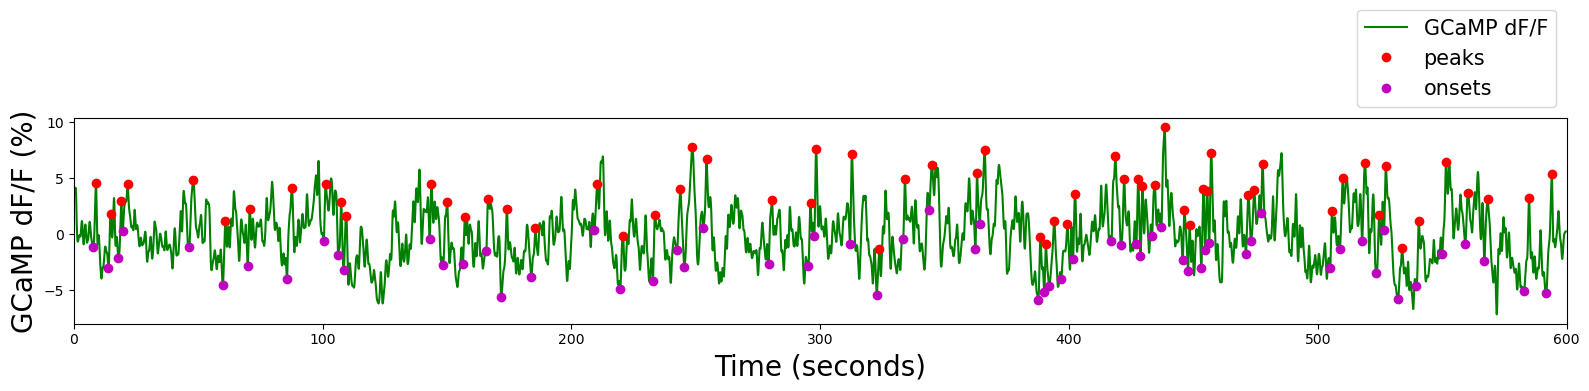

In [7]:
# Plot the dF/F signal with the detected peaks and onsets
fig1 = plt.figure(figsize=(16,9))
ax1=fig1.add_subplot(311)
plot1=ax1.plot(time_sec, signal_dF_F, 'g', label='GCaMP dF/F')
Peaks = ax1.plot(time_sec[Final_peaks], signal_dF_F[Final_peaks], label = 'peaks', color = 'r', marker='o', ls ='')
Onsets = ax1.plot(time_sec[Final_onset], signal_dF_F[Final_onset], label='onsets', color = 'm', marker ='o', ls = "")

# ax1.set_ylim(-10, 15)
ax1.set_xlabel('Time (seconds)', fontsize =20)
ax1.set_ylabel('GCaMP dF/F (%)', color='k', fontsize = 20)

# ax1.set_title('Peak detection')
ax1.set_xlim(0, 600) # 초단위로 입력하여 x-axis zoom in 가능 

lines = plot1 + Peaks + Onsets
labels = [l.get_label() for l in lines]  #get legend labels
legend = ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1, 1), fontsize = 15) #add legend

fig1.tight_layout()

if SavePlots == True:
    plt.savefig('Plot_Peak_detection.png')

In [125]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 1. 데이터 생성
# time = time_sec 
# signal = signal_dF_F

# # 2. 중앙값 및 MAD 계산
# median = np.median(signal)
# mad = np.median(np.abs(signal - median))

# # 3. 초기 임계값 적용: 초기 임계값보다 큰 데이터만 선택
# initial_threshold = median + 1.5 * mad
# filtered_signal = signal[signal > initial_threshold]

# # 4. 최종 임계값 재설정: 초기 임계값을 초과한 데이터의 중앙값으로 계산
# final_threshold = np.median(filtered_signal) + 2 * mad

# # 5. 피크 검출
# peaks = np.where(signal > final_threshold)[0]  # 최종 임계값을 초과하는 인덱스 찾기

# # 6. 데이터 시각화
# plt.figure(figsize=(10, 5))
# plt.plot(time, signal, label='Signal')  # 신호 플롯
# plt.axhline(initial_threshold, color='orange', linestyle='--', label='Initial Threshold')  # 초기 임계값 표시
# plt.axhline(final_threshold, color='red', linestyle='--', label='Final Threshold')         # 최종 임계값 표시
# plt.scatter(time[peaks], signal[peaks], color='red', label='Detected Peaks')               # 검출된 피크 표시
# plt.xlabel('Time (s)')
# plt.ylabel('Signal Amplitude')
# plt.title('Fiber Photometry Data with Detected Peaks')
# plt.legend()
# plt.show()

In [8]:
# detected peaks에 대한 정보를 DataFrame으로 저장 
df_peaks = pd.DataFrame(data={'Peak_Index': Final_peaks,
                              'Peak_X': np.array(time_sec[Final_peaks]), 
                              'Peak_Y': np.array(signal_dF_F[Final_peaks]),
                              'FrameForPeak': np.int64((time_sec[Final_peaks])*FPS),
                              'Onset_Index': np.array(Final_onset),
                              'Onset_X': np.array(time_sec[Final_onset]),
                              'Onset_Y': np.array(signal_dF_F[Final_onset]),
                              'FrameForOnset': np.int64((time_sec[Final_onset])*FPS),
                              'OnsetLatency': np.subtract(np.array(time_sec[Final_peaks]), np.array(time_sec[Final_onset])),
                              'Height': np.subtract(np.array(signal_dF_F[Final_peaks]), np.array(signal_dF_F[Final_onset]))})

print('Number of peaks detected:', len(df_peaks.Peak_Index))
print('Mean amplitude of peaks:', df_peaks.Height.mean())
print('Mean latency of peaks:', df_peaks.OnsetLatency.mean())

if SaveData == True:
    df_peaks.to_csv('Data_Peak_detection.csv', header=True)

Number of peaks detected: 63
Mean amplitude of peaks: 5.83491394001705
Mean latency of peaks: 1.2413142304118057


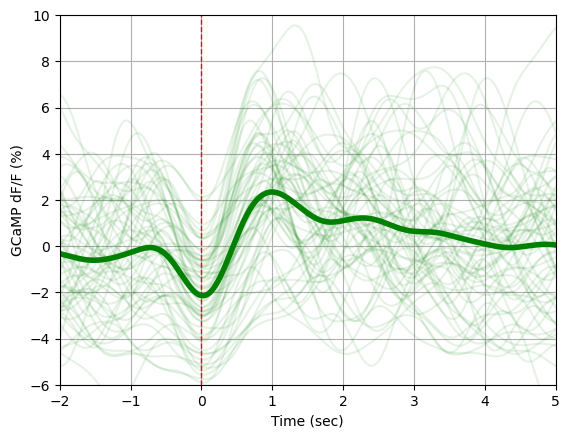

In [12]:
#위에서 찾은 peak들에 대해서 peak onset 1초 전부터 2초 후까지의 Ca2+ trace들을 추출하여 저장함. 
start_time_array = np.array(time_sec[Final_onset])
pre_window_length = 2
post_window_length = 5

all_lines = []
start_time_list = []
end_time_list = []

for time in start_time_array:
    start_time = time - pre_window_length
    end_time = time + post_window_length 
    filtered_data = np.array(GCaMP_signal.value[(time_sec >= start_time) & (time_sec <= end_time)].copy())

    # 시간을 조정하여 데이터 시점을 맞춤
    filtered_data = filtered_data.copy() #SettingWithCopyWarning 참고 
    
    # lineplot 그리기 (투명도를 조절하여 녹색으로 표시)
    min_length = len(filtered_data)
    x_data = (np.linspace(0, pre_window_length + post_window_length, min_length))-pre_window_length
    y_data = filtered_data
    
    line, = plt.plot(x_data, y_data, color='green', alpha=0.1)
    
    all_lines.append(filtered_data)
    start_time_list.append(start_time)
    end_time_list.append(end_time)

all_lines = pd.DataFrame(all_lines)
all_lines_t = all_lines.transpose()

data = all_lines.to_numpy()

df_TimeWindow = pd.DataFrame({'start': start_time_list, 
                              'end': end_time_list})

mean_values = np.nanmean(data, axis=0)
std_values = np.nanstd(data, axis=0)

min_length = min(len(mean_values), len(std_values))
x_data = (np.linspace(0, pre_window_length + post_window_length, min_length))-pre_window_length

# 그래프 제목과 레이블 추가
plt.title('')
plt.xlabel('Time (sec)')
plt.ylabel('GCaMP dF/F (%)')

# 범례 추가
# plt.legend()
plt.grid(True)
plt.ylim(-6, 10)
plt.xlim(-pre_window_length, post_window_length)
plt.axvline(x=0, color = "red", linestyle = '--', linewidth = 1)

plt.plot(x_data, mean_values, color='green', label='Mean Value', linewidth=4)

plt.show()

if SaveData == True:
    all_lines_t.to_pickle(f'Data_Extraced_signal_of_detected_peaks.pkl')
    df_TimeWindow.to_pickle(f'Data_TimeWindow_for_detected_peaks.pkl')

In [ ]:
if SaveVideos == True:
    slices_df = pd.DataFrame({'start_frame': df_peaks.FrameForOnset - pre_window_length*FPS,
                            'end_frame': df_peaks.FrameForPeak + post_window_length*FPS})
    
    VideoFunctions.extract_video_slices(video_path= Animal_ID + '_' + Session + '.avi',
                                    slices_df= slices_df,
                                    output_folder= 'spike_detection')

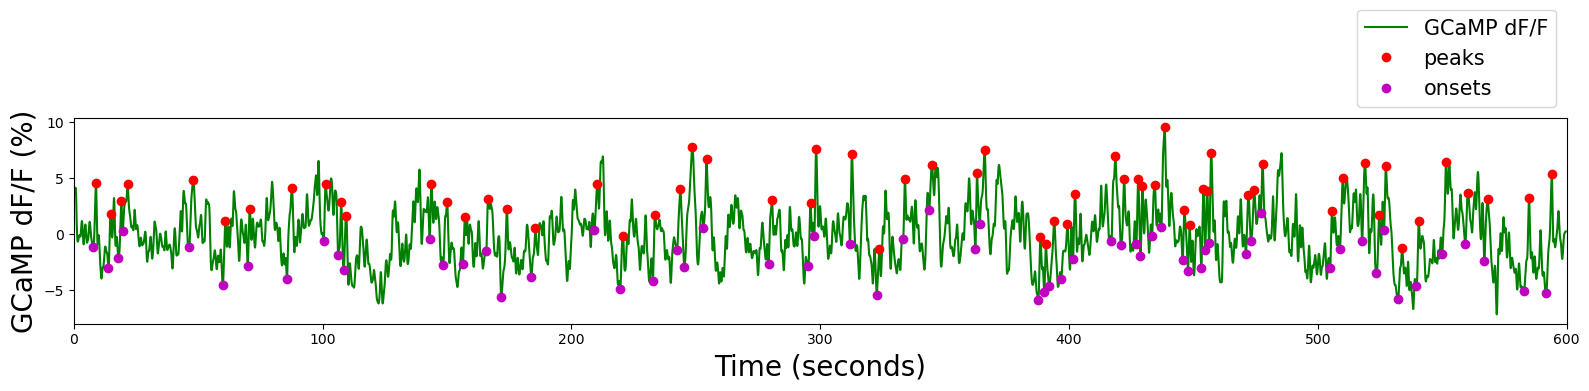

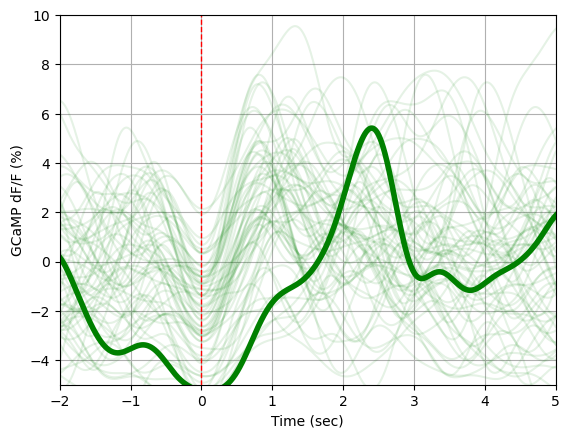

Number of peaks detected: 63
Mean amplitude of peaks: 5.83491394001705
Mean latency of peaks: 1.2413142304118057


In [4]:
import FPFunctions

FPFunctions.Peak_Analysis(pkl_path= os.getcwd(), 
                        prominence_thres= 2, 
                        amplitude_thres= 4, 
                        pre_window_len= 2, 
                        post_window_len= 5, 
                        SavePlots = True, 
                        SaveData = False, 
                        SaveVideos=False,
                        Animal_ID = 'G06_004',
                        Session = 'DI',)